<a href="https://colab.research.google.com/github/mihnguyen/udemy-customer-analytics/blob/main/customer-segmentation/notebook_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Libraries

This notebook follows along [Udemy's Customer Analytics in Python 2020 course, Customer Segmentation section](https://www.udemy.com/course/customer-analytics-in-python/learn/lecture/16844950#content). Some self-exploration and modifications were added here and there.

In [1]:
import numpy as np
import pandas as pd
import scipy

from mpl_toolkits.mplot3d import Axes3D # For plotting in 3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler # For standardizing data to the same scale

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pickle # Turn Python objects into strings
import torch
import torchvision

###Import Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving segmentation data.csv to segmentation data.csv


In [3]:
import io

df_segmentation = pd.read_csv(io.BytesIO(uploaded['segmentation data.csv']), index_col = 0)  # Making ID column an index column

###Explore Data

In [ ]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [ ]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Note: Sex, Marital status, Education, Occupation, Settlement size fields (categorical fields) are assigned with arbitrary numerical values by the dataset creator, as opposed to numerical data that indicate magnitude (like Age, Income).

###Check Correlation

In [ ]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


There seems to be a reasonably high correlation between Age - Education (correlation coefficient = 0.65), and between Occupation - Income (correlation coefficient = 0.68). That makes sense.

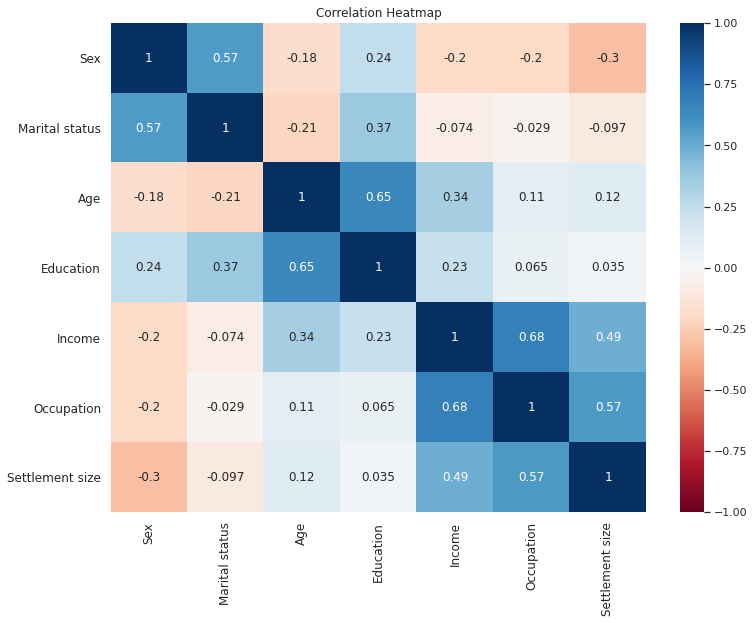

In [ ]:
plt.figure(figsize = (12,9))
s = sns.heatmap(df_segmentation.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1
                )
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap above is quite confusing for the eye to follow, so I looked up [this trick below (from Towards Data Science, "Better Heatmaps and Correlation Matrix Plots in Python" by Drazen Zaric
)](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec) that tweaks and turns scatterplot into representation of **size** and color scales. I made some modifications to the code.

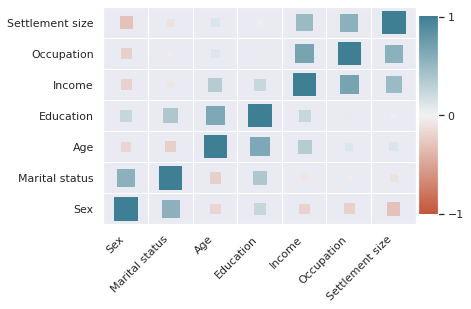

In [ ]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation


# Add colors
def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

# Make a scatter plot with square markers, set column names as labels
def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = x.unique()
    y_labels = y.unique()
    x_to_num = {labels:number for number, labels in enumerate(x_labels)} 
    y_to_num = {labels:number for number, labels in enumerate(y_labels)} 

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot

    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), 
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    # Control the visualization
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 

    
corr = df_segmentation.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

###Visualize Raw Data

Now we're going to make a scatter plot. Remember that Age and Income are the only 2 numerical data in this data set. Thus, let's plot a scatter plot for Age vs. Income.

Text(0.5, 1.0, 'Age vs. Income Raw Data')

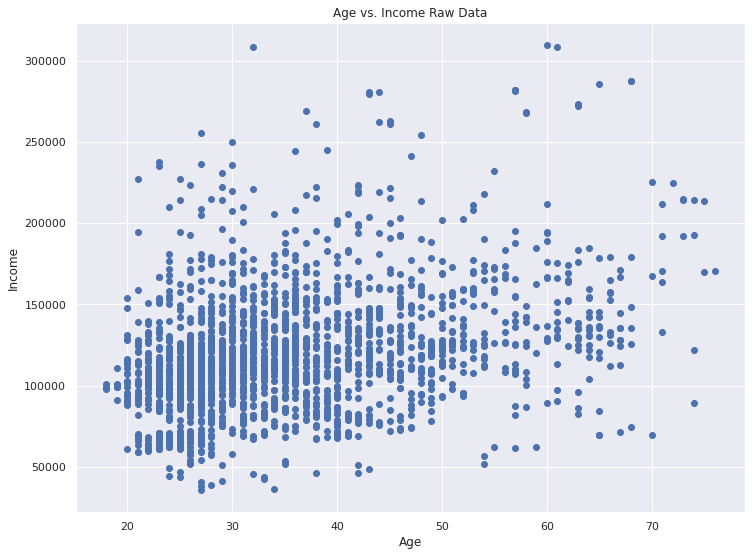

In [ ]:
# Make scatterplot
plt.figure(figsize = (12,9))
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])  # Remember that ID column has become an index column as mentioned before, so position 0 is now Sex
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age vs. Income Raw Data')

According to the correlation check above, there's a very weak to no correlation between Age and Income (correlation = 0.34). The scatter plot confirms this as the data points are quite randomly distributed and spread out.

###Standardize Data

In [41]:
scaler = StandardScaler()
segmentation_standardized = scaler.fit_transform(df_segmentation)

###Apply Hierarchical Clustering

Apply Hierarchical Clustering using Ward method:

In [5]:
hier_clust = linkage(segmentation_standardized, method = 'ward')

Now use Dendrogram to visualize hierarchy tree and segments:

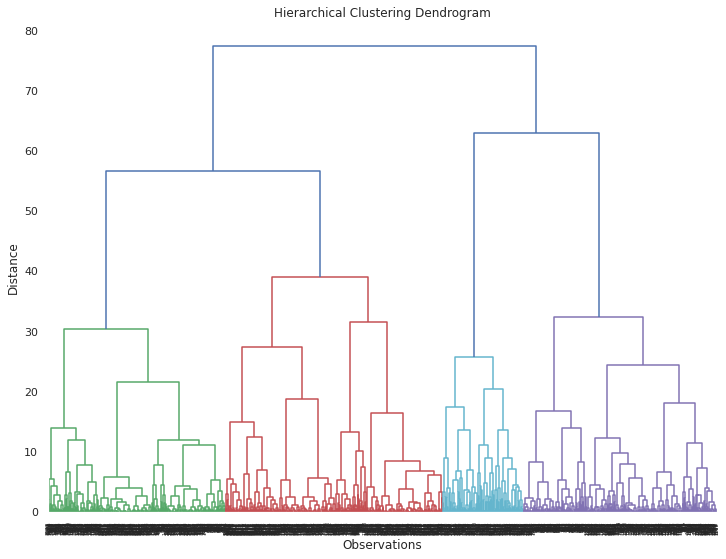

In [6]:
plt.figure(figsize = (12, 9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust, 
           show_leaf_counts = None,
           )
plt.show()

###Apply K-Means Clustering

First, let's determine the best number of clusters.

In [16]:
wcss = [] # Initialize
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, 
                  init = 'k-means++',
                  random_state = 42)
  kmeans.fit(segmentation_standardized)
  wcss.append(kmeans.inertia_)

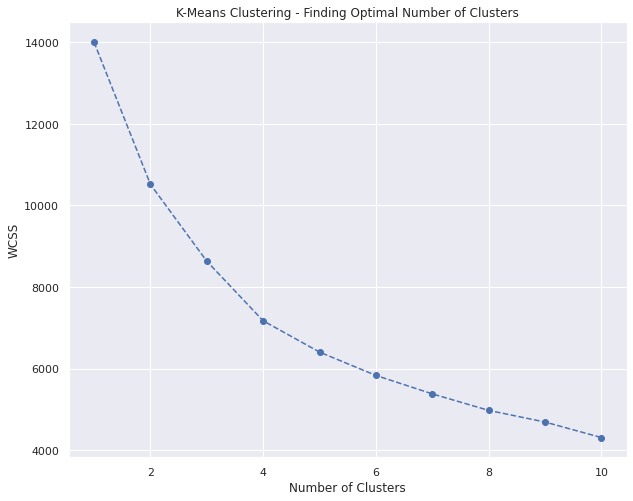

In [17]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Clustering - Finding Optimal Number of Clusters')
plt.show()

Using the Elbow method (find a point in the graph where the upper part is steep while the lower flatter), the number of clusters is 4.
Now is the time to perform K-Means:

In [18]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [19]:
kmeans.fit(segmentation_standardized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

###Interpret & Evaluate Cluster Results

In [ ]:
df_segment_kmeans = df_segmentation.copy() # Why make a copy of the segmentation data?
df_segment_kmeans['Segment K-Means'] = kmeans.labels_ # Add Segment K-Means column, which will contain each observation's predicted clusters, which can be extracted from labels_ attribute
df_segment_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-Means
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,0
100000002,1,1,22,1,150773,1,2,3
100000003,0,0,49,1,89210,0,0,1
100000004,0,0,45,1,171565,1,1,2
100000005,0,0,53,1,149031,1,1,2
...,...,...,...,...,...,...,...,...
100001996,1,0,47,1,123525,0,0,1
100001997,1,1,27,1,117744,1,0,3
100001998,0,0,31,0,86400,0,0,1


Now let's check the characteristics of each segment. We can first check the mean of each segment, group by Segment K-Means column:

In [ ]:
df_segment_analysis = df_segment_kmeans.groupby(['Segment K-Means']).mean()
df_segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-Means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


Observations:
0. First segment (Well-Off): Equal men:women ratio. Over 2/3 have been married. Mean age above 50, also the oldest segment. Highest level of education, income, occupation.

1. Second segment (Fewer-Opportunnities): Mostly men. Almost none in a relationship. Mean age is 35, yet education, occupation, and income are among the lowest. Smallest settlement size, indicating most of this group live outside the city.

2. Third segment (Standard): Mostly women and married. Youngest, with medium level of education, income, occupation.

3. Fourth segment (Career-Focused): Mostly men. Mostly not in a relationship. Lowest level of education but second highest income, occupation. Largest settlement size.

Now let's add Cnt Obs and Segm Proportion columns to check the number of observations in each segment and the segments' proportion.

In [ ]:
df_segment_analysis['Cnt Obs'] = df_segment_kmeans[['Segment K-Means', 'Sex']].groupby(['Segment K-Means']).count() # Review why df_segment_kmeans[['Segment K-Means', 'Sex']]
df_segment_analysis['Segm Proportion'] = df_segment_analysis['Cnt Obs'] / df_segment_analysis['Cnt Obs'].sum()
df_segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cnt Obs,Segm Proportion
Segment K-Means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


Rename the segments:

In [ ]:
df_segment_analysis.rename(
    {
      0: 'well-off',
      1: 'fewer-opportunities',
      2: 'standard',
      3: 'career-focused'
    }
)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cnt Obs,Segm Proportion
Segment K-Means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
standard,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
career-focused,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


Visualize the raw data (instead of the standardized data), this time with the segment labels, in order to roughly evaluate the segmentation results:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


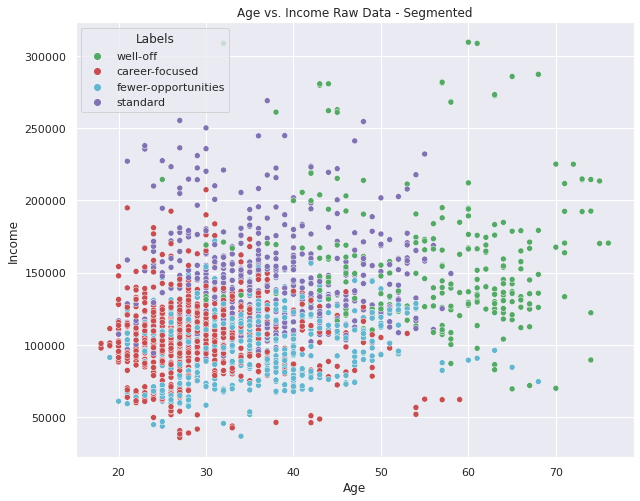

In [ ]:
df_segment_kmeans['Labels'] = df_segment_kmeans['Segment K-Means'].map(
    {0: 'well-off',
      1: 'fewer-opportunities',
      2: 'standard',
      3: 'career-focused'
  }
)

x_axis = df_segment_kmeans['Age']
y_axis = df_segment_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segment_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Age vs. Income Raw Data - Segmented')
plt.show()

Observations: We can see the green segment (Well-Off) is clearly separated. However, it's less clear for the other 3 segments.
Let's see if we could improve the clusters by dropping some variables. To determine which variables to retain for modeling, we'll be using PCA.

###Principal Component Analysis (PCA)

Now, let's perform principal component analysis using sklearn.
The purpose of principal component analysis is to determine which component (variable) has the most impact on the **variability** (variance) of our data. (Number of components = Number of variables)

PCA will give a result (in %) of ranked importance of variables in terms of determining the variance of the data.

In [20]:
pca = PCA()
pca.fit(segmentation_standardized)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

The most important component (or variable) explains 35% of the variability of the data; second component 26%, etc.

Now let's select a subset of these components (or variables), choosing the most important ones since we would want to preserve the variance. Let's find out how many components to select / keep by plotting the number of components against .

Text(0, 0.5, 'Cumulative Explained Variance')

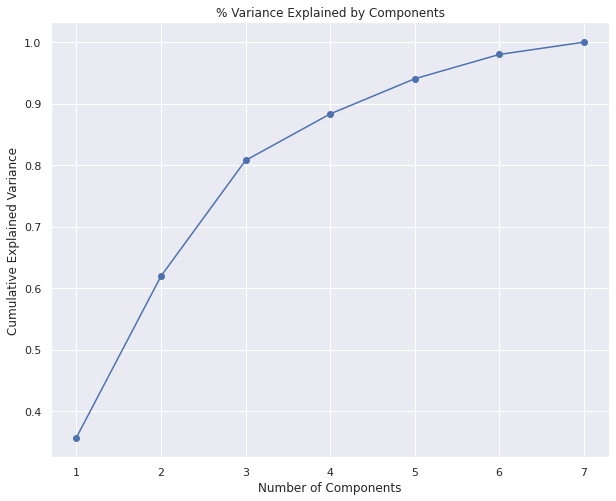

In [22]:
plt.figure(figsize = (10, 8))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('% Variance Explained by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Rule of thumb is to pick anumber of components that would keep 70% or 80% of the variance (not higher, since that wouldn't reduce any components; not lower, since we want to preserve the variability).
According to the plot above, that correlates to 3 components to keep in this case.

Now fit 3 components into the data and drop the rest of the variables.

In [23]:
pca = PCA(n_components = 3)
pca.fit(segmentation_standardized)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

####Test PCA 4 components

Above I selected 3 components (which explains about 80% of the variance). Let's see how different the results would be between 3 components and 4 components.

In [24]:
pca_4 = PCA(n_components = 4)
pca.fit(segmentation_standardized)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

###PCA Results

Check correlation between the 3 components and all of the 7 original features (or variables) in the dataset:

In [25]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

Let's visualize the correlations by first loading the 3x7 array above into a dataframe:

In [26]:
# Load the correlations above into a dataframe
df_pca_comp_corr = pd.DataFrame(data = pca.components_,
                                columns = df_segmentation.columns.values,
                                index = ['Component 1', 'Component 2', 'Component 3']
                                ) 
df_pca_comp_corr

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


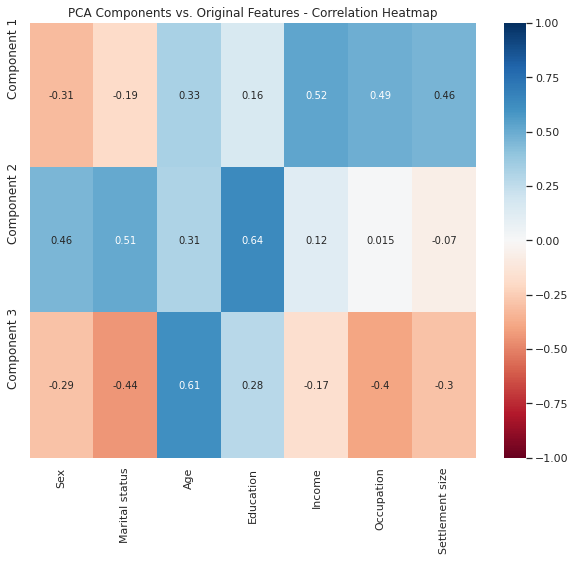

In [27]:
plt.figure(figsize = (10,8))
sns.heatmap(df_pca_comp_corr,
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1
                )
plt.yticks([0, 1, 2], 
                  ['Component 1', 'Component 2', 'Component 3'],
                  # rotation = 0,
                  fontsize = 12
                  )
# plt.xticks(rotation = 0)
plt.title('PCA Components vs. Original Features - Correlation Heatmap')
plt.show()

Observations:
- Component 1: has positive correlation with Income, Occupation, Settlement size, Age. -> This component is about career.
- Component 2: correlates the most with Education, Marital Status, Sex, while almost no correlation with the other career-related features. -> This component probably refers to an individual's education and lifestyle.
- Component 3: correlates the most with Age, Marital Status, Occupation.

But how is our original data related to these 
Our original data has 7 dimensions (7 variables). Now that we've selected 3 components, let's transform the original data into 3 dimensions.

In [28]:
pca.transform(segmentation_standardized)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [29]:
scores_pca = pca.transform(segmentation_standardized) # Using standardized data

###K-Means Clustering with PCA
Let's do K-Means Clustering again, this time with the PCA applied.

In [43]:
wcss = [] # Initialize
for i in range(1,11):
  kmeans_pca = KMeans(n_clusters = i, 
                  init = 'k-means++',
                  random_state = 42)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

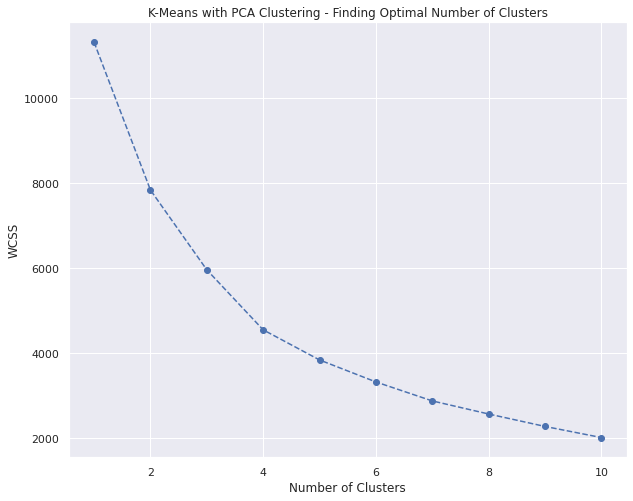

In [44]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Clustering - Finding Optimal Number of Clusters')
plt.show()

This resulting plot is very similar to the previous [K-Means Clustering](https://colab.research.google.com/drive/19Gveo7lCdMonc_c3-jBPqigefoymkziE#scrollTo=mZFbHgo2IgJj). We'll pick 4 clusters.
Now fit scores_pca into the model:

In [45]:
kmeans_pca = KMeans(
    n_clusters = 4,
    init = 'k-means++',
    random_state = 42
)

kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

###K-Means Clustering with PCA Results

Recall that previously we have identified the characteristics of the components as follows:
- Component 1: Career
- Component 2: Education & Lifestyle
- Component 3: Experience

So we'll name the new columns (components) accordingly:

In [33]:
# Concatenating original dataframe with the scores_pca dataframe

df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = 'True'), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1 (Career)', 'Component 2 (Education & Lifestyle)', 'Component 3 (Experience)']
df_segm_pca_kmeans['K-Means PCA Segments'] = kmeans_pca.labels_

df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1 (Career),Component 2 (Education & Lifestyle),Component 3 (Experience),K-Means PCA Segments
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,3
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,3
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,1
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


Now check the means to see if we could identify the characteristics of the newly created 4 segments:

In [34]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['K-Means PCA Segments']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1 (Career),Component 2 (Education & Lifestyle),Component 3 (Experience)
K-Means PCA Segments,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953
1,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493
2,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925
3,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046


Remember that previously the following 4 groups have been established: Well-Off, Fewer-Opportunities, Career-Focused, and Standard.

Let's see if we could identify those same 4 groups with the results of mean values we obtained just now:
- Segment with the highest Component 1 (Career), 2 (Education & Lifestyle), and 3 (Experience) – at 1.70, 2.03, 0.84, respectively – describes characteristics of the oldest group: Well-Off.
- Segment with low Component 1 (Career) and Component 2 (Education & Lifestyle) but high Component 3 (Experience) – at -1.05, -0.90, 1.01, respectively – corresponds to: Fewer-Opportunities.
- Segment with high Component 1 (Career), but lowest Component 2 (Education & Lifestyle) – at 1.37, -1.05, -0.25, respectively – describes characteristics of: Career-Focused.
- The remaining segment with medium Component values indeed describes: Standard.

Now, let's rename the segments accordingly and check the distribution of each segment within the dataset by adding columns to count the nunmber of observations and segment proportion:

In [35]:
df_segm_pca_kmeans_freq['Cnt Obs'] = df_segm_pca_kmeans[['K-Means PCA Segments', 'Sex']].groupby(['K-Means PCA Segments']).count() # Review why df_segment_kmeans[['Segment K-Means', 'Sex']]
df_segm_pca_kmeans_freq['Segm Proportion'] = df_segm_pca_kmeans_freq['Cnt Obs'] / df_segm_pca_kmeans_freq['Cnt Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0: 'well-off',
                                                          1: 'fewer-opportunities',
                                                          2: 'standard',
                                                          3: 'career-focused'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1 (Career),Component 2 (Education & Lifestyle),Component 3 (Experience),Cnt Obs,Segm Proportion
K-Means PCA Segments,,,,,,,,,,,,
well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,264,0.1320
fewer-opportunities,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493,459,0.2295
standard,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925,694,0.3470
career-focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915


Standard segments account for 35% of the dataset, then Career-Focused at 29%, then Fewer-Opportunities, and Well-Off.
Now let's check what the segments look like in 2D by picking out just 2 out of the 3 components. In this case, let's pick Component 1 and 2 as an example:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


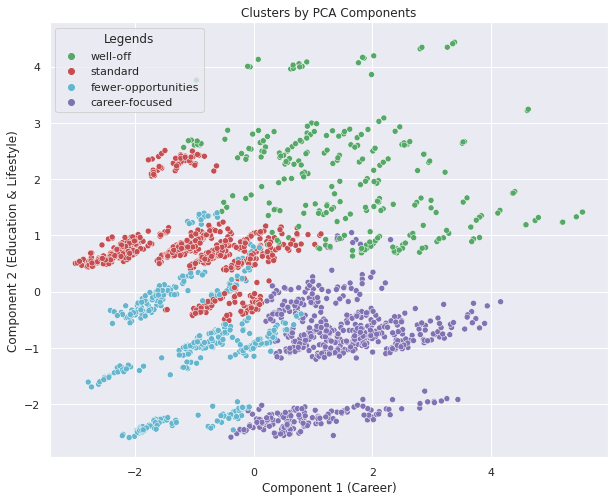

In [36]:
df_segm_pca_kmeans['Legends'] = df_segm_pca_kmeans['K-Means PCA Segments'].map({0: 'well-off',
                                                                                1: 'fewer-opportunities',
                                                                                2: 'standard',
                                                                                3: 'career-focused'})

x_axis = df_segm_pca_kmeans['Component 1 (Career)']
y_axis = df_segm_pca_kmeans['Component 2 (Education & Lifestyle)']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legends'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

Compared to the [previous clustering without PCA](https://colab.research.google.com/drive/19Gveo7lCdMonc_c3-jBPqigefoymkziE#scrollTo=F3137VNyAPMz), we now can clearly see the clusters:
- Well-Off segment in green with high both high components
- Fewer-Opporunities in cyan with both low components
- Career-Focused in magenta with low Education & Lifestyle but high in Career
- Standard low in Career (being the youngest group) but high in Education & Lifestyle

Below let's try plotting in 3D. There are still overlaps.

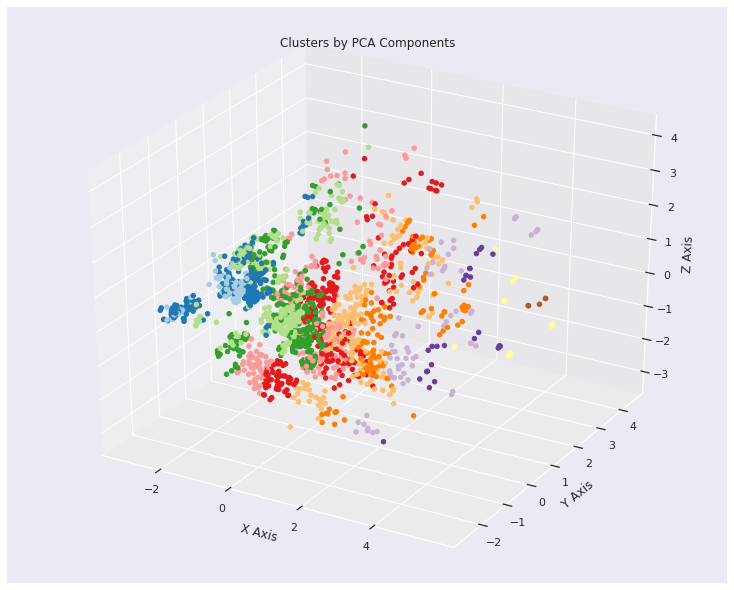

In [37]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

x = df_segm_pca_kmeans['Component 1 (Career)'].to_numpy()
y = df_segm_pca_kmeans['Component 2 (Education & Lifestyle)'].to_numpy()
z = df_segm_pca_kmeans['Component 3 (Experience)'].to_numpy()

g = ax.scatter(x, y, z, c=x, depthshade=False, cmap='Paired')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('Clusters by PCA Components')

plt.show()

### Data Export
Use pickle to export for use later (Purchase Analytics in the course) without having to run the whole notebook.

In [54]:
pickle.dump(scaler, open('scaler.pickle', 'wb')) # Export the standardized data
pickle.dump(pca, open('pca.pickle', 'wb'))
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))